In [1]:
import local_models.local_models as lm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import local_models.loggin
import local_models.TLS_models
from local_models.TLS_models import LinearRegression, QuadraticRegression, SphericalRegression, LinearODR

logger = logging.getLogger(__name__)

np.random.seed(1)
reload(local_models.local_models)
reload(local_models.loggin)
reload(local_models.TLS_models)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
np.warnings.filterwarnings('ignore')

In [26]:
n = 100
sigma = 0.1
K = 14

In [18]:
X1 = np.linspace(0.,2.,n)
X2 = np.linspace(0.,2.,n)

In [45]:
y1 = 3*X1 + 7 + np.random.normal(0,sigma,n)

In [46]:
y2 = 3*X2 + 2 + np.random.normal(0,sigma,n)

In [47]:
c = np.concatenate((np.ones(n), np.zeros(n)))

In [48]:
y = np.concatenate((y1,y2))
x = np.concatenate((X1,X2))

In [49]:
print(x.shape, y.shape)

(200,) (200,)


In [50]:
noisy_lines = np.stack((x,y)).T
noisy_lines.shape

(200, 2)

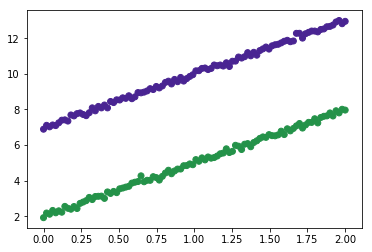

In [51]:
plt.scatter(x,y,c=cmap(c))
plt.show()

In [52]:
kernel = lm.TriCubeKernel(bandwidth='knn',k=K)
linear_models = lm.LocalModels(LinearODR())
linear_models.fit(noisy_lines)

In [53]:
linear_params = linear_models.transform(noisy_lines,k=K,weighted=True,distance_transform=kernel)

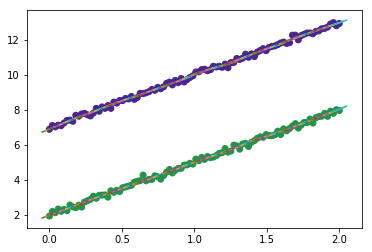

In [54]:
plt.scatter(noisy_lines[:,0], noisy_lines[:,1],c=cmap(c))
span = np.linspace(-0.05,0.05,10)
for i in range(noisy_lines.shape[0]):
    x,y = noisy_lines[i]
    plt.plot(span + x, (1-linear_params[i,0]*(span+x))/linear_params[i,1])
#plt.xlim(0,0.8)
#plt.ylim(-.8,0)
plt.show()

In [55]:
RANGE_PCT = 0.1
data = noisy_lines
min_data, max_data = np.min(data, axis=0), np.max(data, axis=0)
data_range = max_data - min_data
how_much_to_include_outside_range = 0.1*data_range
data_ranges = np.stack((min_data - how_much_to_include_outside_range, max_data + how_much_to_include_outside_range)).T
data_step = ((data_ranges[:,1] - data_ranges[:,0])/100)
grid_limits = tuple(map(lambda i: slice(data_ranges[i][0], data_ranges[i][1], data_step[i]), range(data_ranges.shape[0])))
g = np.mgrid[grid_limits]
xx = np.vstack(map(np.ravel, g)).T
g_like_shape = [-1] + list(g.shape[1:])

In [56]:
xx_linear_params = linear_models.transform(xx,k=K,weighted=True,distance_transform=kernel)
xx_linear_params.shape

(10000, 2)

In [57]:
projected_xx = np.zeros(xx.shape)
for i in range(len(xx_linear_params)):
    lr = LinearODR()
    lr.coef_ = xx_linear_params[i]
    projected_xx[i] = lr.project(xx[i])

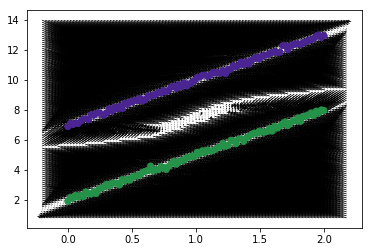

In [58]:
changes = projected_xx
plt.quiver(xx[:,0], xx[:,1], changes[:,0], changes[:,1], scale=10)
plt.scatter(noisy_lines[:,0], noisy_lines[:,1],c=cmap(c))
#plt.xlim(1.5,2)
#plt.ylim(-0.4,0.2)

plt.show()

In [ ]:
import scipy.optimize
def projection_length(x,linear_models,k,weighted,distance_transform):
    pt_params = linear_models.transform(x.reshape((1,-1)), k=k, weighted=weighted, distance_transform=distance_transform)
    l = LinearRegression()
    l.coef_ = pt_params[0]
    return np.linalg.norm(l.project(x))

blarg = []
for i in range(noisy_lines.shape[0]):
    print(i)
    pt = noisy_lines[i]
    solution = scipy.optimize.minimize(projection_length, pt, args=(linear_models, K, True, kernel))
    blarg.append(solution.x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


In [ ]:
blarg = np.array(blarg)
plt.scatter(blarg[:,0], blarg[:,1])
plt.scatter(noisy_lines[:,0], noisy_lines[:,1],c=cmap(c))
plt.show()